# Stable diffusion with Diffusers

This is a notebook that demonstrates how to use the [Diffusers package](https://huggingface.co/docs/diffusers/index) from Huggingface to run stable diffusion. [Huggingface](https://huggingface.co) is a community-driven  platform that provides a comprehensive suite of open-source libraries and tools for machine learning. Think of it as a kind of "github for machine learning". The diffusers package provides a simple API and a number of pretrained models that allow to easily run and experiment with diffusion models. 

**NOTE** this notebook should work on other platform, but it has been only tested on Mac (M1). 

## Installation
To use this notebook you will need to install diffusers with
```
pip install --upgrade diffusers\[torch\]
pip install transformers
```

## Running stable diffusion
To run stable diffusion you will need to distinguish wether you are running this on a Mac M1/M2 or on Linux/Windows with a Nvidia GPU. 
On a M1/M2 Mac, diffusion will need a "warmup" phase to work properly (see [this link](https://huggingface.co/docs/diffusers/optimization/mps))

In [1]:
import platform
import torch
import numpy as np
import matplotlib.pyplot as plt

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)


cuda


Now this will load the pretrained model and download it the first time the cell is run (which might take a while). You can set the model version by modifying the `sd_version` variable. Read [this document](https://huggingface.co/docs/diffusers/en/stable_diffusion) for performance recommendations and tricks.

In [111]:
from diffusers import StableDiffusionPipeline
from diffusers import DPMSolverMultistepScheduler

sd_version = '2.1'

if sd_version == '2.1':
    model_key = "stabilityai/stable-diffusion-2-1-base"
elif sd_version == '2.0':
    model_key = "stabilityai/stable-diffusion-2-base"
elif sd_version == '1.5':
    model_key = "runwayml/stable-diffusion-v1-5"

pipe = StableDiffusionPipeline.from_pretrained(model_key, torch_dtype=torch.float16, use_safetensors=True)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config) # Faster scheduler
pipe = pipe.to(device)

if device=='mps':
    # Recommended if your computer has < 64 GB of RAM
    pipe.enable_attention_slicing()
if device=='cuda':
    pipe.enable_attention_slicing()

Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  4.31it/s]


Generate the image (note increasing `num_inference_steps` will improve quality but be slower)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:02<00:00,  7.18it/s]


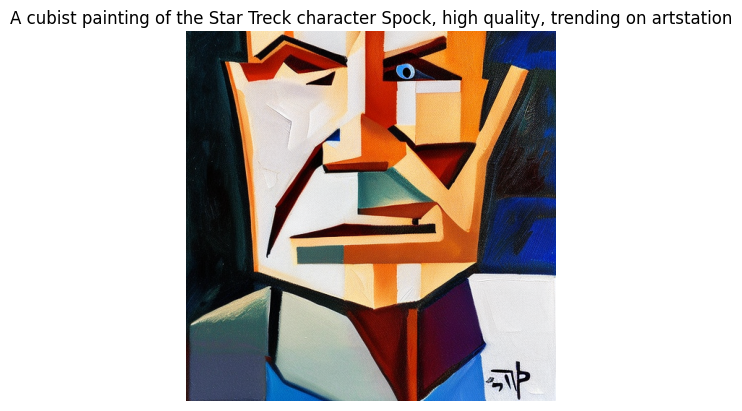

In [113]:
generator = torch.Generator(device).manual_seed(0) # Removing manual_seed will always generate different images 

prompt = "A cubist painting of the Star Treck character Spock, high quality, trending on artstation"
image = pipe(prompt, guidance_scale=7.5, generator=generator, num_inference_steps=20).images[0]

plt.imshow(np.array(image))
plt.title(prompt)
plt.axis('off')
plt.show()

## Text guided image to image generation
We can use stable diffusion also with a "seed image", so let's load Spock. Note that using the `PIL.Image` class, we can view an image by simply putting the variable as the last statement of a cell.       

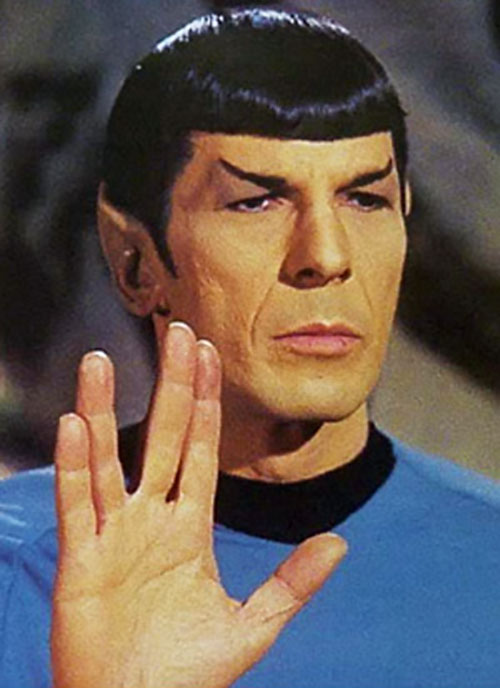

In [119]:
from PIL import Image 

seed_image = Image.open("images/spock.jpg")
seed_image

Now let's load the [`StableDiffusionImg2ImgPipeline`](https://huggingface.co/docs/diffusers/en/api/pipelines/stable_diffusion/img2img) model, similarly to what we did earlier with the normal stable diffusion pipeline:

In [117]:
from diffusers import StableDiffusionImg2ImgPipeline

pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_key, torch_dtype=torch.float16, use_safetensors=True)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config) # Faster scheduler
pipe = pipe.to(device)

if device=='mps':
    # Recommended if your computer has < 64 GB of RAM
    pipe.enable_attention_slicing()
if device=='cuda':
    pipe.enable_attention_slicing()

Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00,  6.93it/s]


The [`StableDiffusionImg2ImgPipeline`] takes an additional `image` parameter that conditions the diffusion process so that the result is similar to a given image:

100%|██████████| 14/14 [00:03<00:00,  4.12it/s]


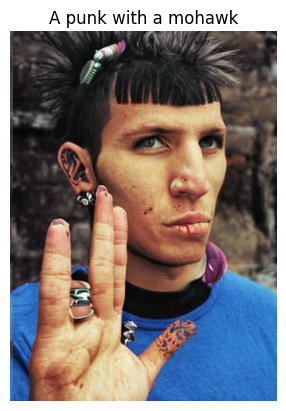

In [136]:
prompt = "A punk with a mohawk"
image = pipe(prompt, image=seed_image, guidance_scale=7.5, strength=0.7, generator=generator, num_inference_steps=20).images[0]

plt.imshow(np.array(image))
plt.title(prompt)
plt.axis('off')
plt.show()

Well at least we can try...

The diffusers API provides a number of [other pipelines](https://huggingface.co/docs/diffusers/en/api/pipelines/stable_diffusion/overview) that can be useful for other tasks, such as image inpainting or depth-to-image.

## Conditioning stable diffusion with ControlNet

[ControlNet](https://openaccess.thecvf.com/content/ICCV2023/papers/Zhang_Adding_Conditional_Control_to_Text-to-Image_Diffusion_Models_ICCV_2023_paper.pdf) is a very recent and quite amazing advancement in image generation using stable diffusion. It allows conditioning the stable diffusion generation pipeline on an image input (similarly to pix2pix).  This system operates by integrating a smaller neural network with a pre-trained stable diffusion model. The weights of the stable diffusion model are frozen, and the combined model is trained to steer stable diffusion towards producing images consistent with the provided input conditions.

The Huggingface diffusers API comes with ControlNet and a number of pre-trained models that can be used for an number of tasks such as guiding stable diffusion with edges, poses or depth maps (see [https://huggingface.co/lllyasviel/sd-controlnet-canny](https://huggingface.co/lllyasviel/sd-controlnet-canny) for some available models).

Here we will use the ["sd-controlnet-canny"](https://huggingface.co/lllyasviel/sd-controlnet-canny) model, which guides stable diffusion with edge images. Let's start by using skimage to create edges from an input image, as we did with pix2pix:

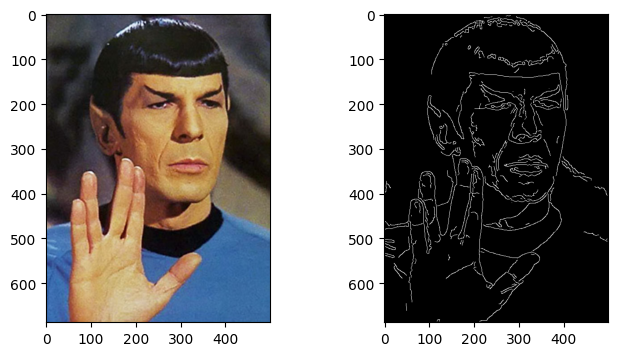

In [91]:
import numpy as np
from skimage import io, feature, transform
import PIL.Image as Image
import cv2

def apply_canny_skimage(img, sigma=1.5, size=512):
    import cv2
    from skimage import feature
    invert = False
    grayimg = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = (feature.canny(grayimg, sigma=sigma)*255).astype(np.uint8)
    if invert:
        edges = cv2.bitwise_not(edges)
    return cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)

img = io.imread("images/spock.jpg")
edges =  apply_canny_skimage(img)

# ControlNet expects a PIL Image as input
edges_image = Image.fromarray(edges)

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(edges)
plt.show()

Now we setup the ControlNet model. Note that the current HuggingFace version of ControlNet requires Stable Diffusion 1.5 to run: 

In [97]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import PIL.Image as Image

controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-canny", 
    torch_dtype=torch.float16)
    
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", # Controlnet is currently working only with SD 1.5
    torch_dtype=torch.float16,
    controlnet=controlnet, 
    safety_checker=None)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config) # Faster scheduler
print("converting to device")
pipe = pipe.to(device)

if device=='mps':
    pipe.enable_attention_slicing()
if device=='cuda':
    pipe.enable_attention_slicing()

Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00,  8.47it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


converting to device


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:05<00:00,  3.99it/s]


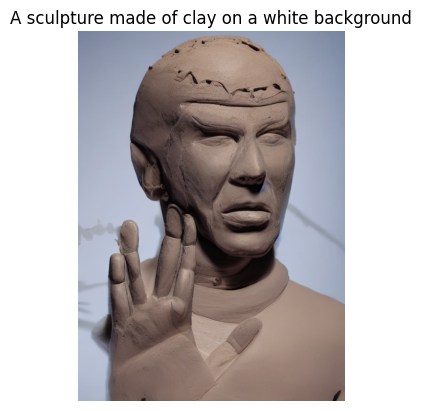

In [96]:
prompt = "A sculpture made of clay on a white background"

generator = torch.Generator(device).manual_seed(0) # Removing manual_seed will always generate different images 

image = pipe(
    prompt,
    image=edges_image,
    generator=generator,
    num_inference_steps=20,
).images[0]

plt.imshow(np.array(image))
plt.title(prompt)
plt.axis('off')
plt.show()

# Procedural input

In the previous example, we used edge detection to produce the ControlNet condition image. However, you can create interesting visual results also by procedurally generating an "edge-like" image, similarly to some examples we used with Pix2Pix.  

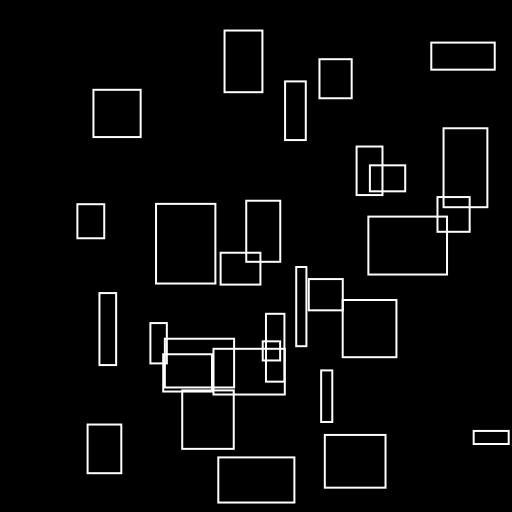

In [137]:
from py5canvas import canvas
c = canvas.Canvas(512, 512)

np.random.seed(123)
c.background(0)
c.stroke_weight(2)
c.stroke(255)
c.no_fill()
#c.set_rect_mode('center')
for i in range(30):
    c.rectangle(np.random.uniform(0, c.width, 2), np.random.uniform(10, 80, 2))
#c.polygon(np.random.uniform(0, c.width, (100,2)))

img = c.get_image()
edges_image = Image.fromarray(img)
# Simply writing a PIL image as the last step of a code cell will visualize it
edges_image

For this case, we may get better results by using the ["sd-controlnet-scribble"](https://huggingface.co/lllyasviel/sd-controlnet-scribble) model, which is similar to the Canny edge detection model, but is trained on scribble-like images instead of edge maps. 

In [139]:
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-scribble", 
    torch_dtype=torch.float16)
    
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", # Controlnet is currently working only with SD 1.5
    torch_dtype=torch.float16,
    controlnet=controlnet, 
    safety_checker=None)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config) # Faster scheduler
print("converting to device")
pipe = pipe.to(device)

if device=='mps':
    pipe.enable_attention_slicing()
if device=='cuda':
    pipe.enable_attention_slicing()

Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00,  7.80it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


converting to device


This time, we will also add a "negative prompt", which is a caption describing outputs we wish to avoid 

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:04<00:00,  4.53it/s]


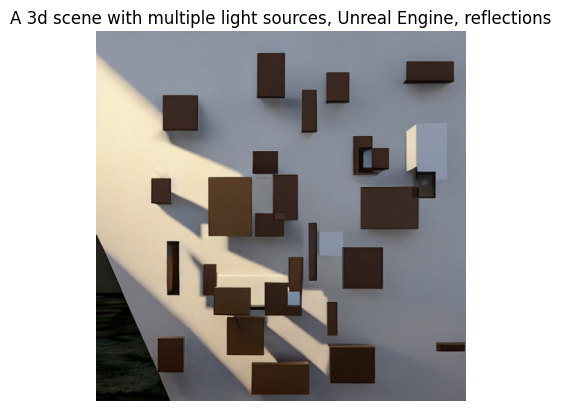

In [141]:
prompt = "A 3d scene with multiple light sources, Unreal Engine, reflections"

generator = torch.Generator(device).manual_seed(420) # Removing manual_seed will always generate different images 

image = pipe(
    prompt,
    negative_prompt="blurry, user interface, captions",
    image=edges_image,
    generator=generator,
    controlnet_conditioning_scale=1.0,
    guidance_scale=7.5, 
    num_inference_steps=20,
).images[0]

plt.imshow(np.array(image))
plt.title(prompt)
plt.axis('off')
plt.show()